# Кластеризация

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
geo = pd.read_excel("geo.xlsx")
geo_comment = pd.read_excel("geo_comment.xlsx")

In [5]:
display(geo.head())
display(geo_comment.head())

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [9]:
display(geo.columns)
display(geo_comment.columns)

Index(['Unnamed: 0', 'x', 'y', 'comment_class'], dtype='object')

Index(['Unnamed: 0', 'x', 'y', 'comment_class', 'multiplier', 'comment'], dtype='object')

In [6]:
display(geo.info())
display(geo_comment.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
Unnamed: 0       108806 non-null int64
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70382 entries, 0 to 70381
Data columns (total 6 columns):
Unnamed: 0       70382 non-null int64
x                70382 non-null float64
y                70382 non-null float64
comment_class    70382 non-null int64
multiplier       70382 non-null int64
comment          70382 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 3.2+ MB


None

In [10]:
print(geo.shape, geo_comment.shape)

(108806, 4) (70382, 6)


**Исключаю "Unnamed: 0" из geo_comment т.к. это индексация, также поскольку информация в geo и в geo_comment идентичная, далее работа будет только с geo_comment**

In [17]:
geo_comment.drop(columns=['Unnamed: 0'], inplace=True)

In [24]:
geo_comment.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


**Изучим выбросы в данных и посмотрим какие классы у нас есть**

In [23]:
df_info_null = geo_comment.isnull().sum()

print(df_info_null, '\n')
print('Итого выбросов в данных: {}'.format(df_info_null.sum()))

x                0
y                0
comment_class    0
multiplier       0
comment          0
dtype: int64 

Итого выбросов в данных: 0


In [29]:
geo_comment.comment_class.value_counts()

-1    58552
 1    11830
Name: comment_class, dtype: int64

**Посмотрим на дубликаты в комментариях**

In [25]:
geo_comment.comment.duplicated().value_counts()

True     63047
False     7335
Name: comment, dtype: int64

**Сгруппирую df чтобы уменьшить дубликаты по всей видимости multiplier было не 1 по описанию данных**

In [31]:
geo_comment_max = geo_comment.groupby(by=['comment'],as_index=False).max()
geo_comment_sum = geo_comment.groupby(by=['comment'],as_index=False).sum()

geo_comment_cleaned = geo_comment_max.filter(['comment', 'x', 'y', 'comment_class'], axis=1)
geo_comment_cleaned['multiplier'] = geo_comment_sum['multiplier']

In [33]:
geo_comment_cleaned.head(30)

,comment,x,y,comment_class,multiplier
0,"""В 2010 году жителями была остановлена попытка...",37.545276,55.794436,-1,409
1,"""О проекте Правил землепользования и заст...",37.639033,55.740781,-1,4
2,"""ООО """"Ласточка"""" является собственником 2 зем...",37.529322,55.762145,1,1
3,"""ООО «БУТАКОВСКИЙ», рассмотрев материалы предс...",37.647387,55.883792,-1,2
4,"""Проект планировки территории, ограниченной Ни...",37.470051,55.669625,-1,2
5,"""ТРЕБУЮ ОТКЛОНИТЬ ПРОЕКТ ПРАВИЛ ЗЕМЛЕПОЛЬЗОВАН...",37.530274,55.606711,-1,1
6,"""Требую представленный на публичные слушания п...",37.476842,55.804491,-1,240
7,"""Уважаемые господа,\nПрошу вас обратить вниман...",37.692528,55.873370,-1,6
8,"""рыба"" письма на предмет нарушения прав жителе...",37.692528,55.873370,-1,6
9,"(Новопесчаная ул., д.12 - Кинотеатр ""Ленинград...",37.513305,55.883792,-1,4


In [34]:
geo_comment_cleaned.comment.duplicated().value_counts()

False    7335
Name: comment, dtype: int64

**Получили достаточно сбалансированные данные по классам**

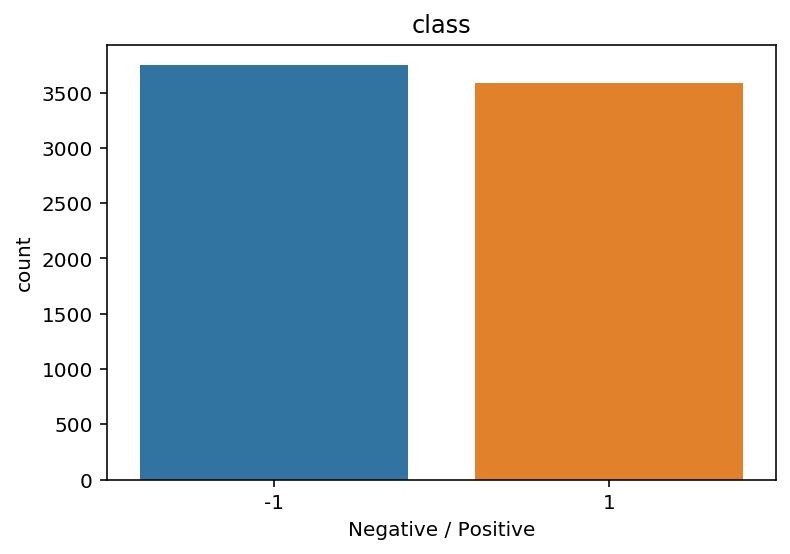

In [45]:
ax = plt.axes()
sns.countplot(x='comment_class', data=geo_comment_cleaned, ax=ax)
plt.xlabel('Negative / Positive')
ax.set_title('class')
plt.show()

In [37]:
geo_comment_cleaned.comment_class.value_counts()

-1    3745
 1    3590
Name: comment_class, dtype: int64

**Перед кластеризацией нормализуем X и Y дабы уменьшить размерность в данных и подогнать к одной размерности**

In [46]:
ss = StandardScaler()
geo_comment_cleaned[['x', 'y']] = ss.fit_transform(geo_comment_cleaned[['x', 'y']])

In [50]:
geo_comment_cleaned.describe()

,x,y,comment_class,multiplier
count,7.335000e+03,7.335000e+03,7335.000000,7335.000000
mean,5.060165e-15,-1.041282e-13,-0.021132,14.833810
std,1.000068e+00,1.000068e+00,0.999845,153.410564
min,-3.321637e+00,-3.769673e+00,-1.000000,1.000000
25%,-8.966486e-01,-7.050360e-01,-1.000000,1.000000
50%,-4.517540e-02,1.583863e-01,-1.000000,1.000000
75%,7.624678e-01,8.635122e-01,1.000000,2.000000
max,3.199241e+00,2.797997e+00,1.000000,5910.000000


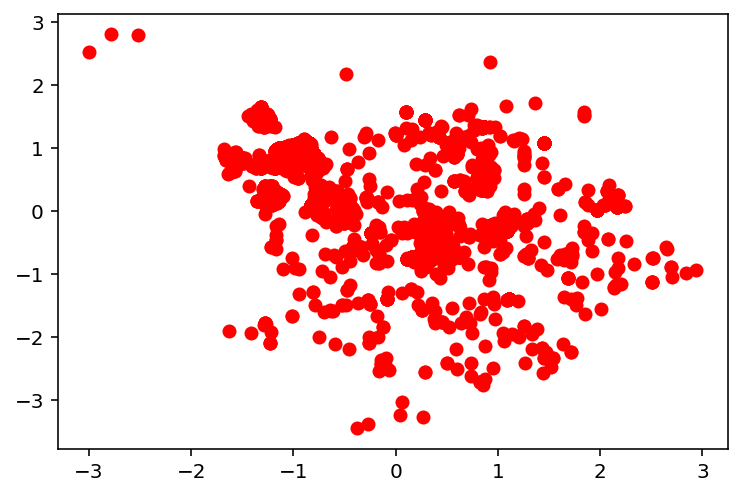

In [74]:
yes = geo_comment_cleaned[geo_comment_cleaned['comment_class'] == 1]

plt.scatter(
    yes.x, 
    yes.y, 
    c='r'
);

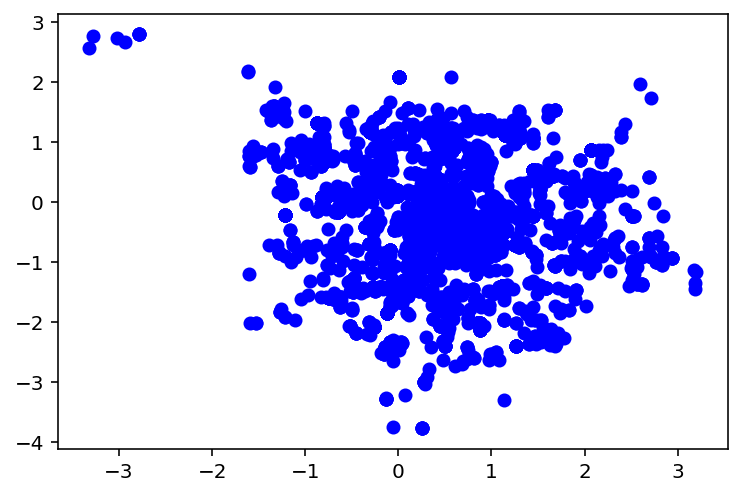

In [73]:
no = geo_comment_cleaned[geo_comment_cleaned['comment_class'] != 1]

plt.scatter(
    no.x, 
    no.y, 
    c='b'
);

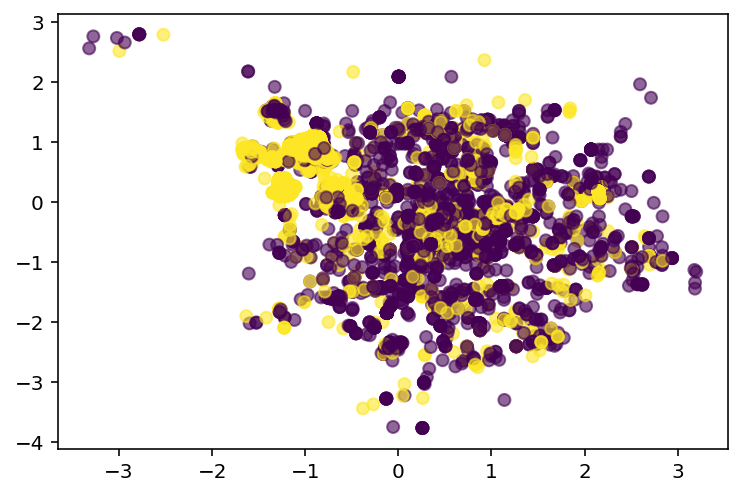

In [71]:
plt.scatter(
    geo_comment_cleaned.x, 
    geo_comment_cleaned.y, 
    c=geo_comment_cleaned.comment_class, 
    alpha=0.6
);

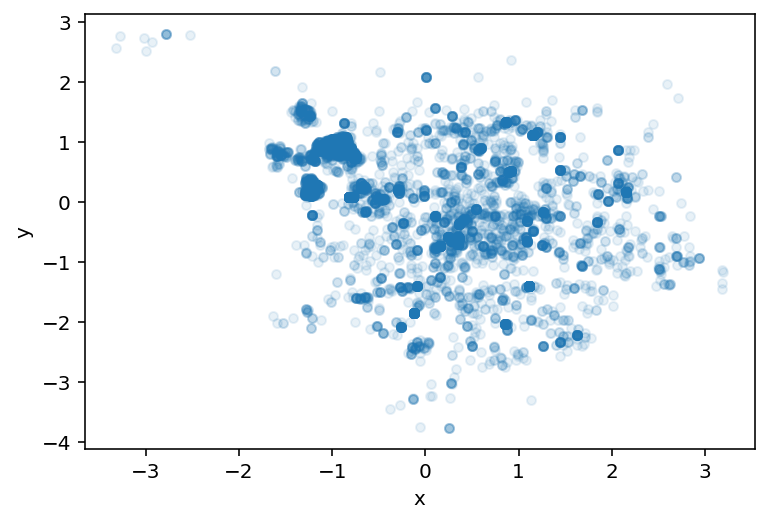

In [81]:
_ = geo_comment_cleaned.plot(kind="scatter", x='x', y='y', alpha=0.1);

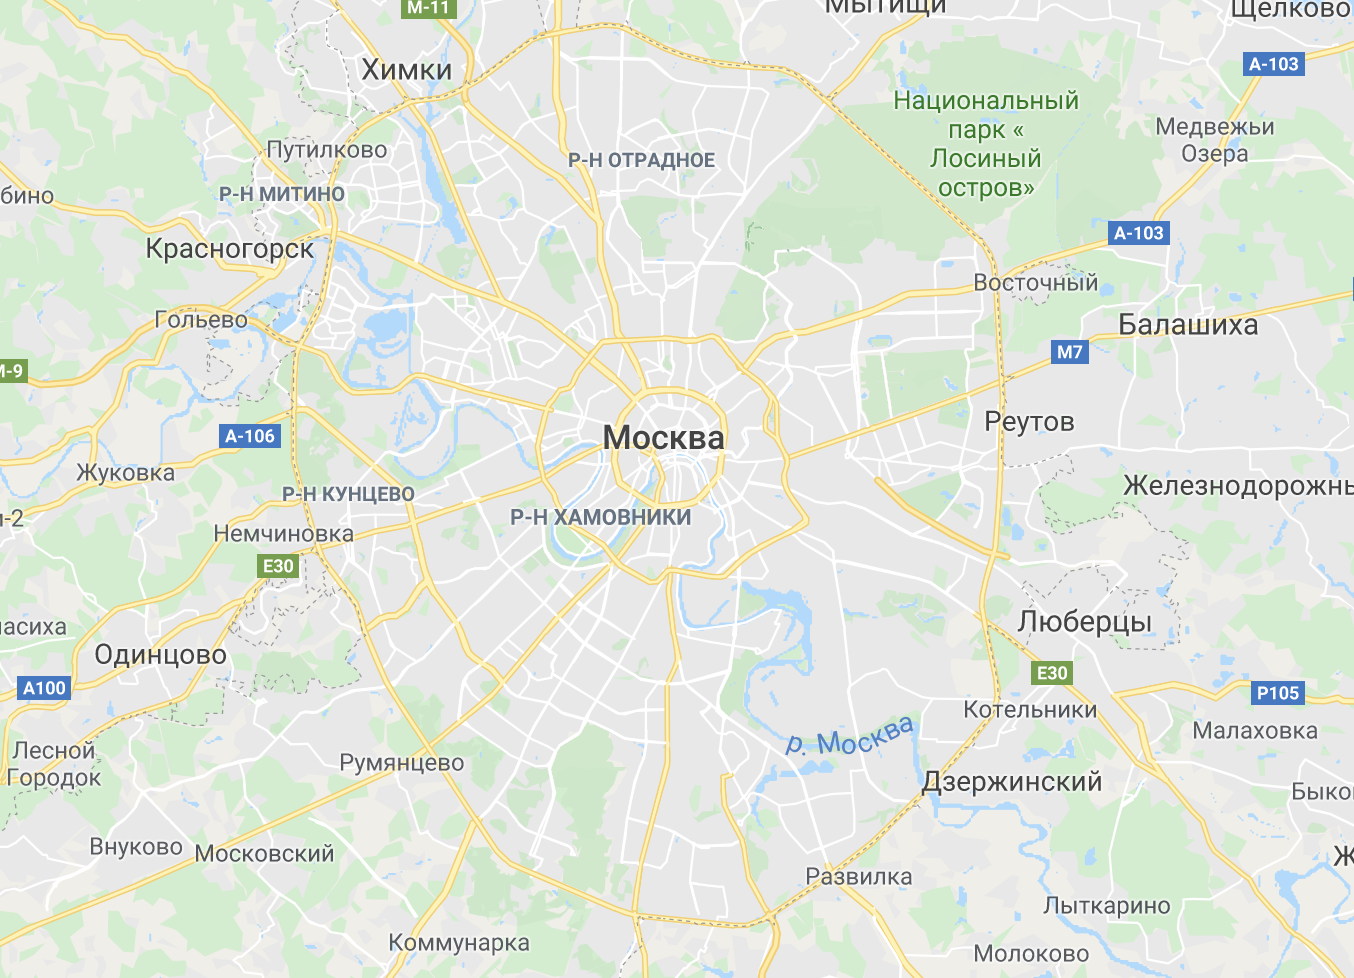

In [90]:
Image('Screenshot 2019-10-24 at 17.31.58.png')

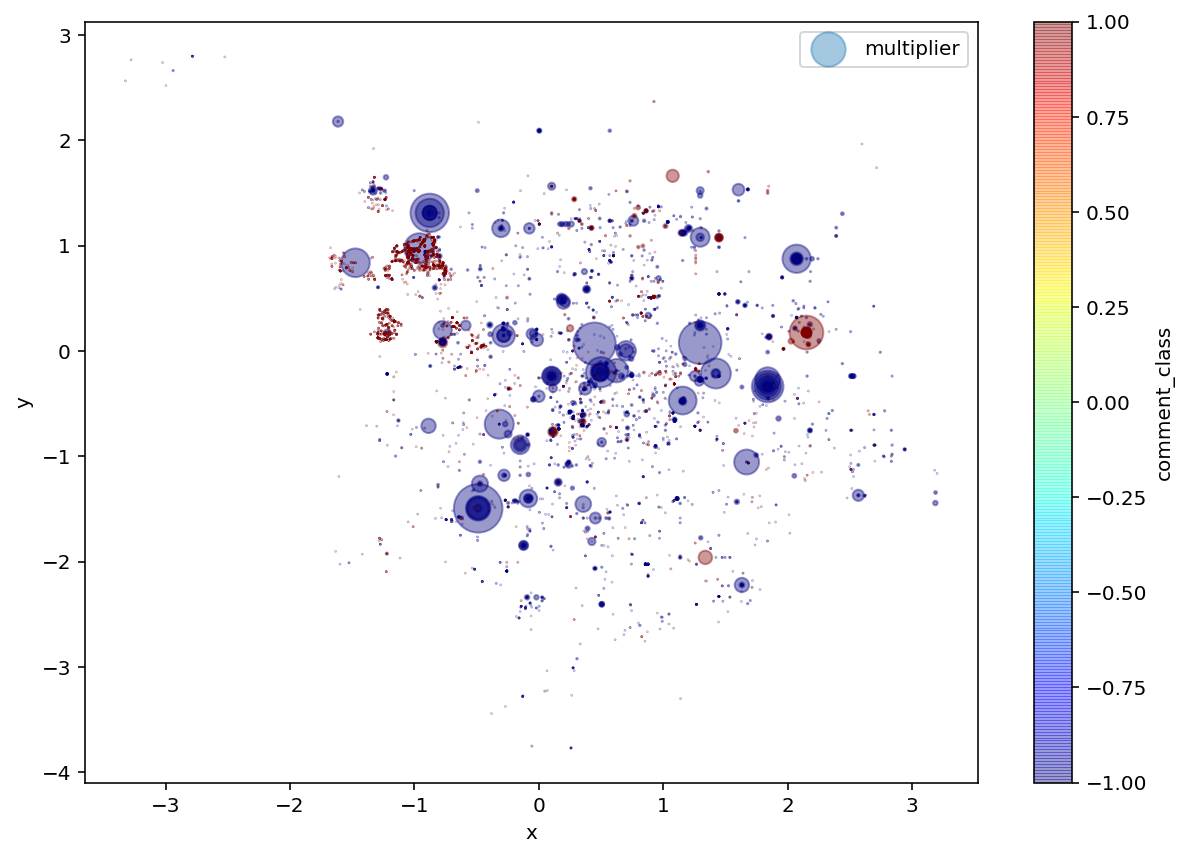

In [103]:
geo_comment_cleaned.plot(kind="scatter", x="x", y="y", alpha=0.4,
    s=geo_comment_cleaned["multiplier"]/10, label="multiplier", figsize=(10,7),
    c="comment_class", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
_ = plt.legend()

**Попробуем кластеризовать (╯ ° □ °) ╯ ┻━┻**

- Визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
- Подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)

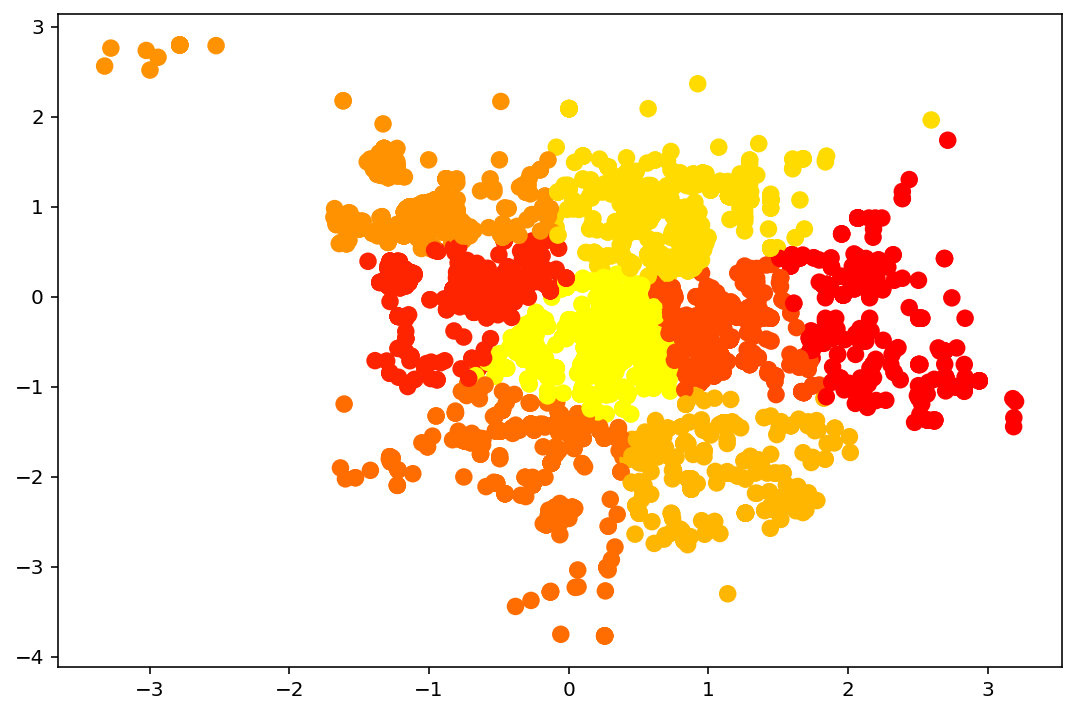

In [105]:
kmeans = KMeans()
out = kmeans.fit_predict(geo_comment_cleaned[['x', 'y']])

plt.scatter(geo_comment_cleaned.x, geo_comment_cleaned.y, c=out, cmap='autumn', s=60)
plt.show()

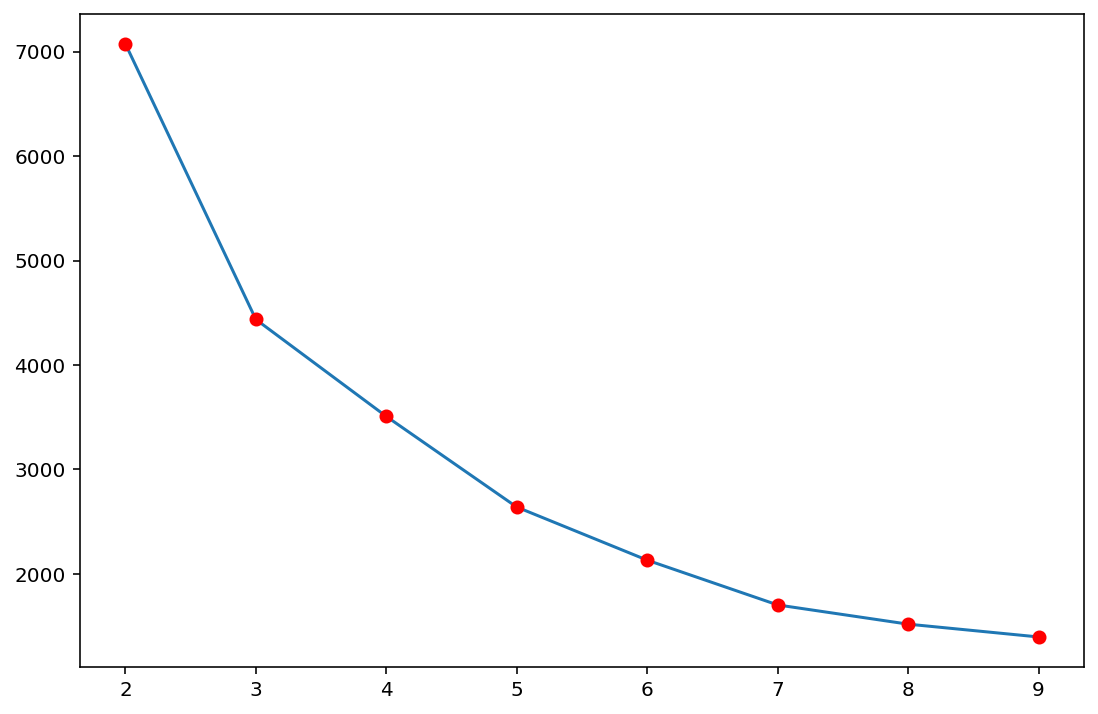

In [123]:
intertias = []
ks = list(range(2, 10))

for k in ks:
    mns = KMeans(n_clusters=k)
    mns.fit(geo_comment_cleaned[['x', 'y']])
    intertias.append(mns.inertia_)

plt.plot(ks, intertias)
plt.plot(ks, intertias, 'ro');

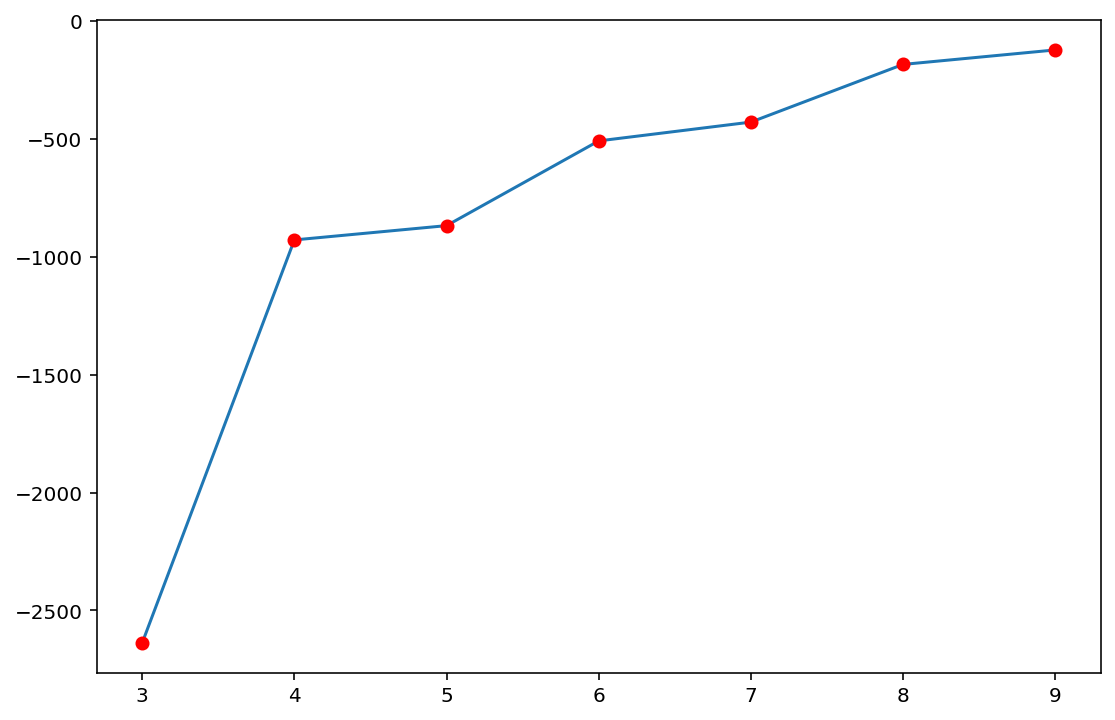

In [128]:
diff = np.diff(intertias)
plt.plot(ks[1:], diff)
plt.plot(ks[1:], diff, 'ro');

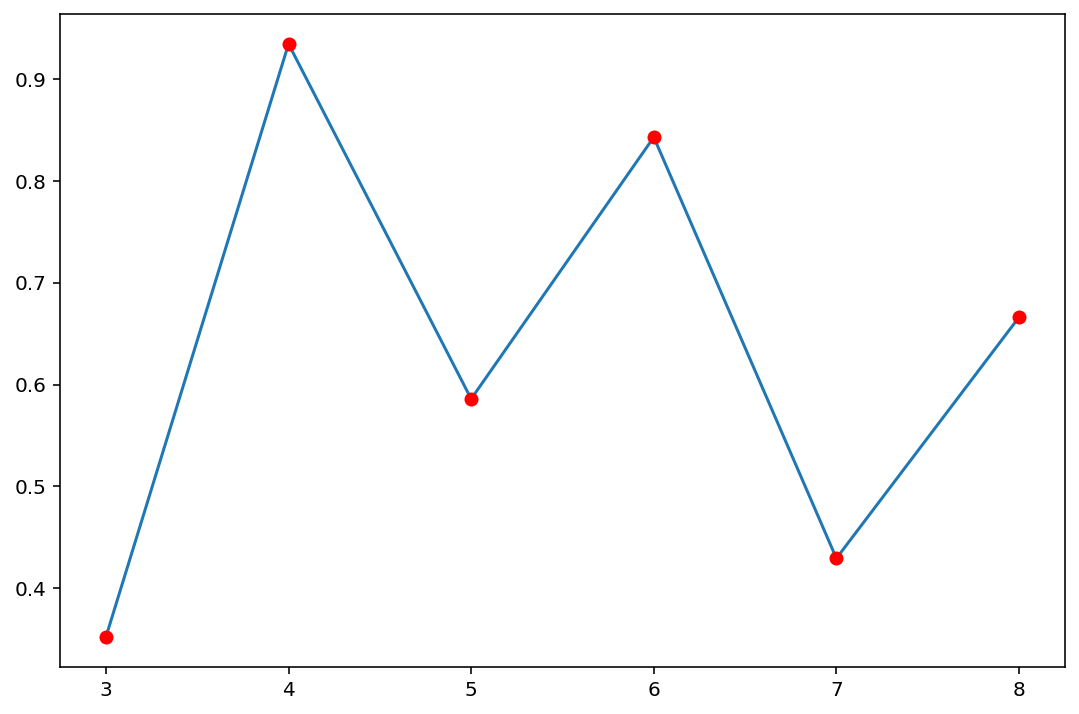

In [129]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.plot(ks[1:-1], diff_r, 'ro');

In [130]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

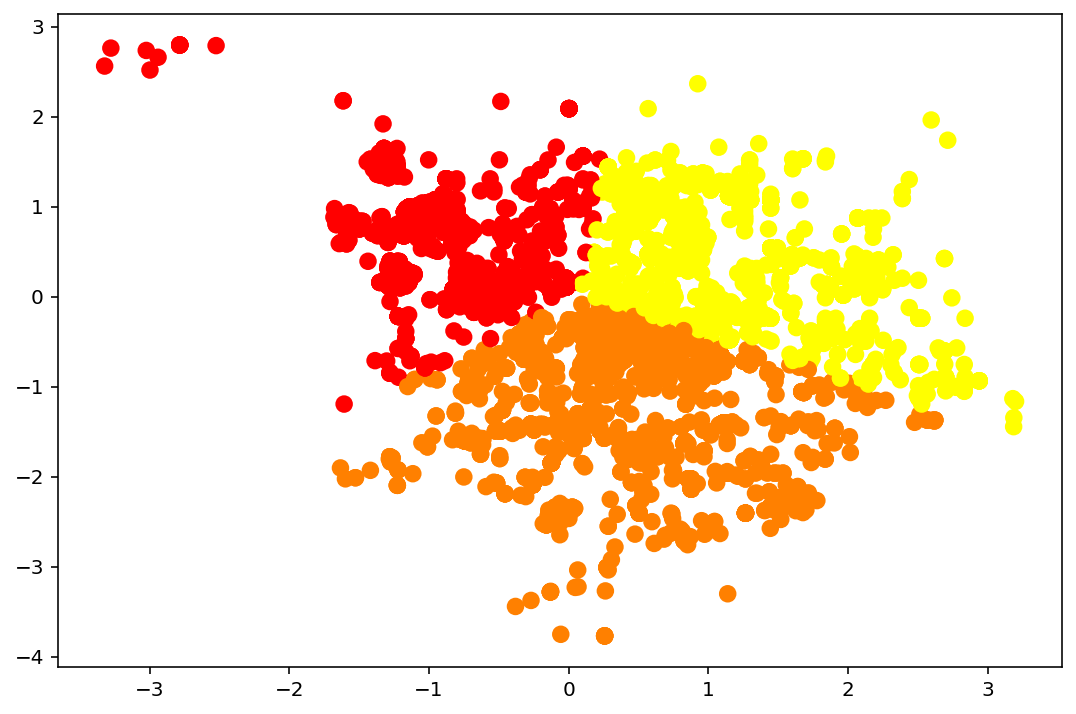

In [132]:
kmeans = KMeans(n_clusters=k_opt)
out = kmeans.fit_predict(geo_comment_cleaned[['x', 'y']])

plt.scatter(geo_comment_cleaned.x, geo_comment_cleaned.y, c=out, cmap='autumn', s=60)
plt.show()

In [136]:
print('ARI: {}'.format(adjusted_rand_score(geo_comment_cleaned.y, out)))
print('SIL: {}'.format(silhouette_score(geo_comment_cleaned[['x', 'y']], out)))

ARI: 0.01721618518957002
SIL: 0.5143144689352855


- Аналогично исследовать скопления голосов за и против отдельно
- Подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)

**Yes**

In [ ]:
# yes = geo_comment_cleaned[geo_comment_cleaned['comment_class'] == 1]
# no = geo_comment_cleaned[geo_comment_cleaned['comment_class'] != 1]

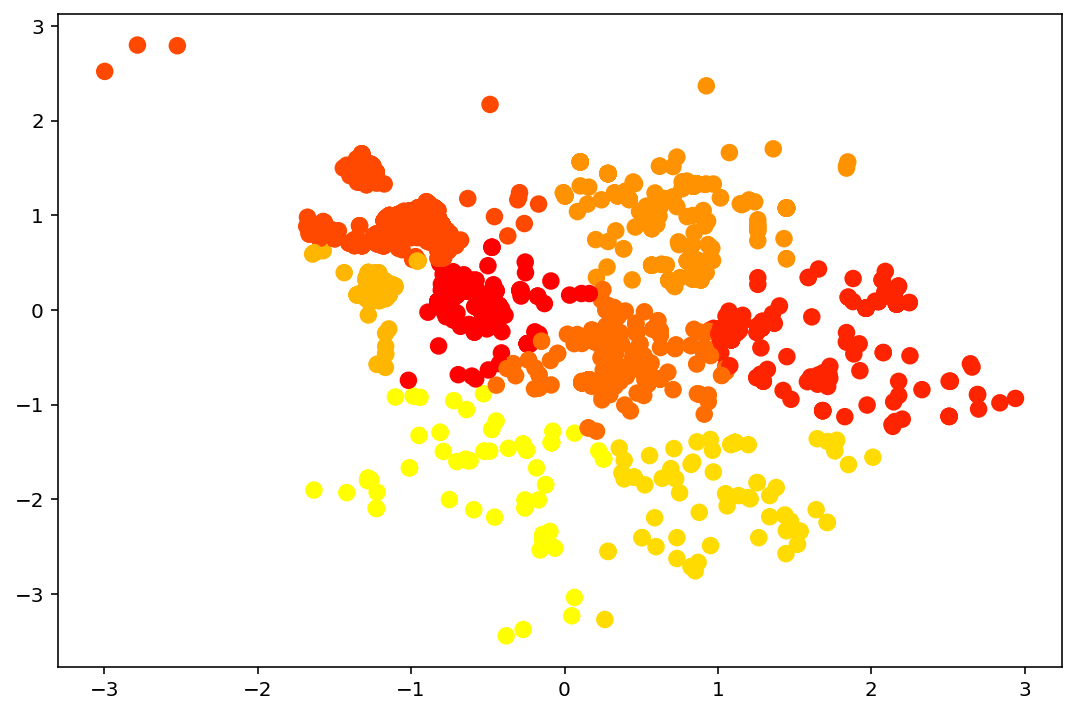

In [137]:
kmeans = KMeans()
out = kmeans.fit_predict(yes[['x', 'y']])

plt.scatter(yes.x, yes.y, c=out, cmap='autumn', s=60)
plt.show()

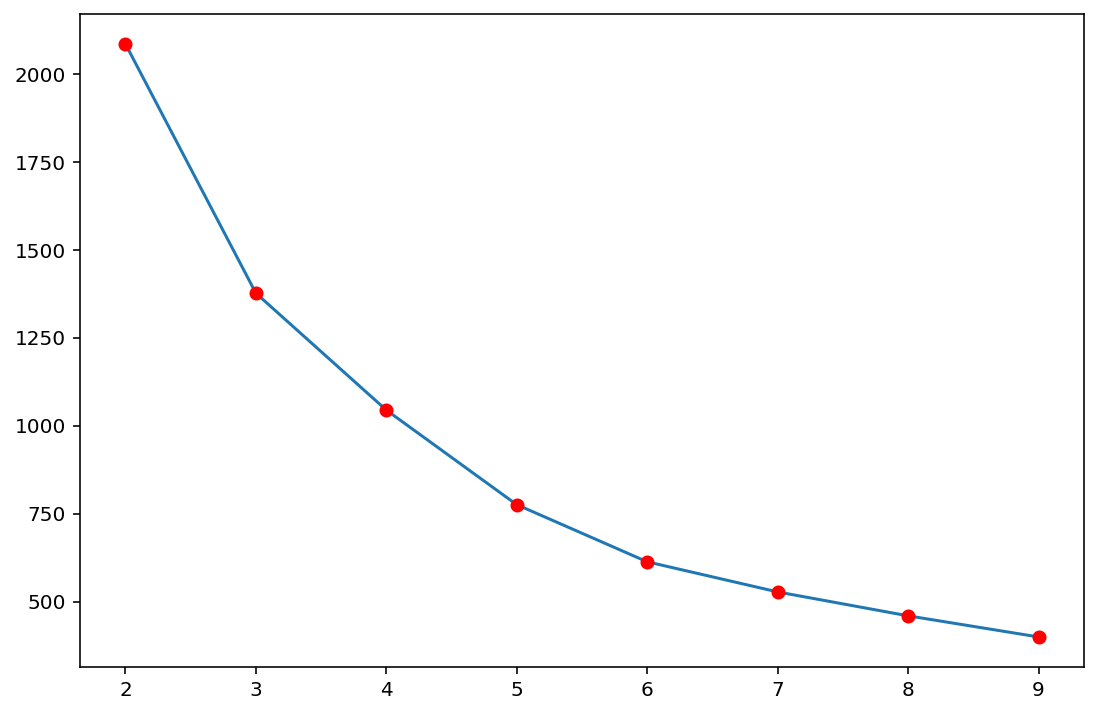

In [138]:
intertias = []
ks = list(range(2, 10))

for k in ks:
    mns = KMeans(n_clusters=k)
    mns.fit(yes[['x', 'y']])
    intertias.append(mns.inertia_)

plt.plot(ks, intertias)
plt.plot(ks, intertias, 'ro');

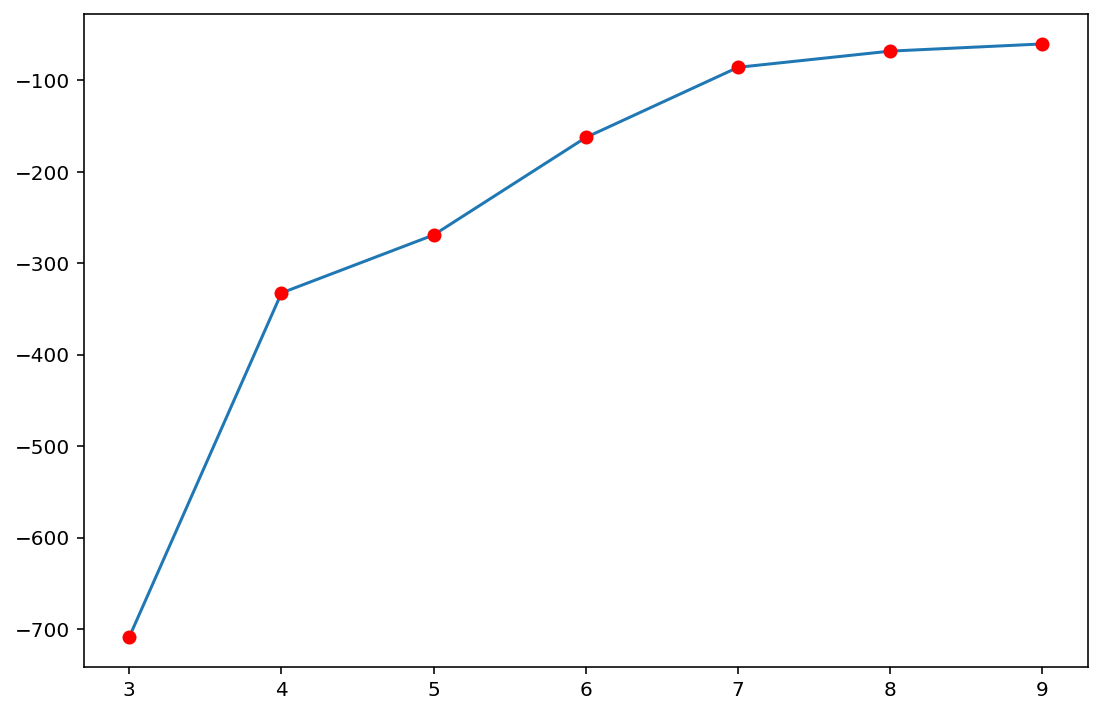

In [139]:
diff = np.diff(intertias)
plt.plot(ks[1:], diff)
plt.plot(ks[1:], diff, 'ro')

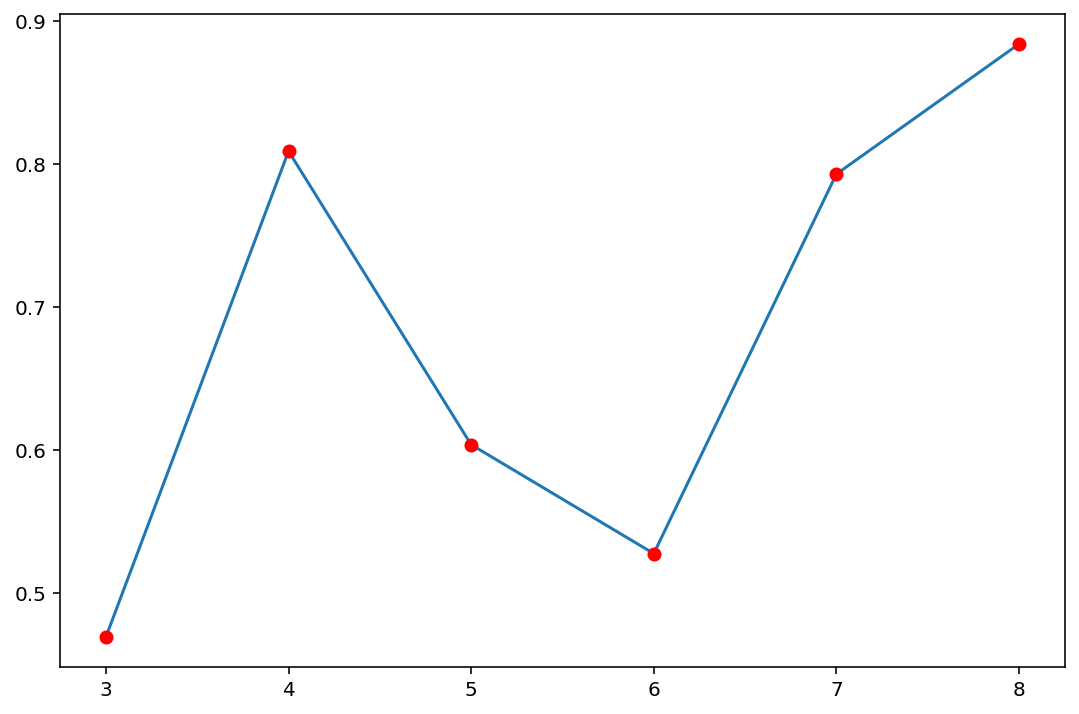

In [140]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.plot(ks[1:-1], diff_r, 'ro');

In [141]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

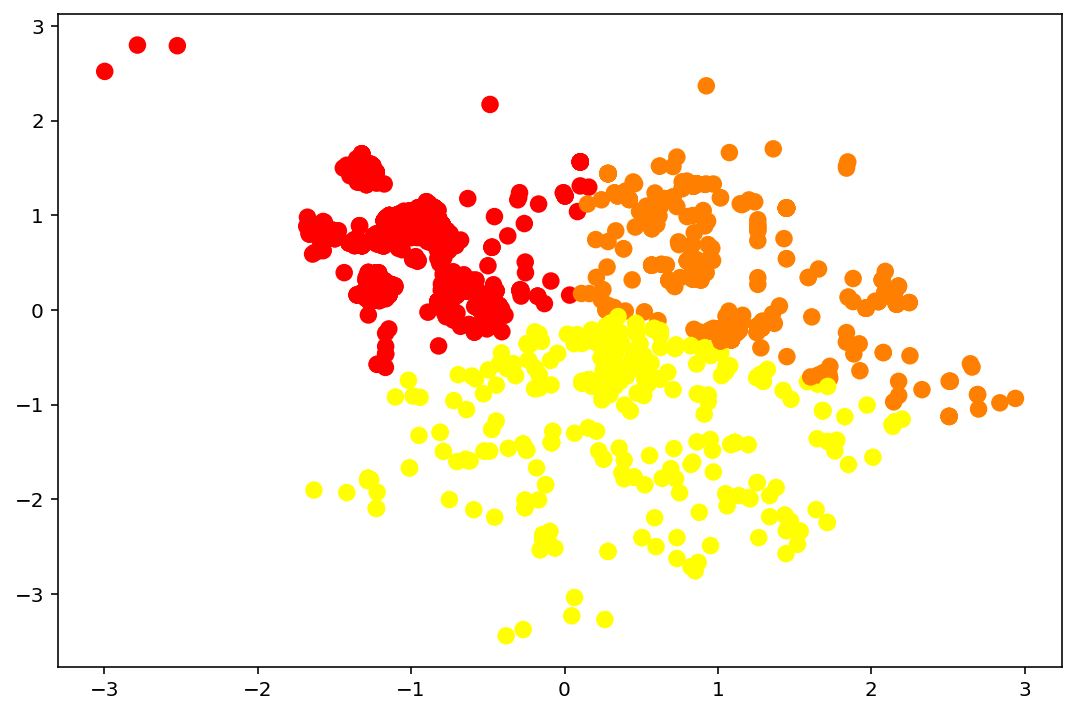

In [142]:
kmeans = KMeans(n_clusters=k_opt)
out = kmeans.fit_predict(yes[['x', 'y']])

plt.scatter(yes.x, yes.y, c=out, cmap='autumn', s=60)
plt.show()

In [143]:
print('ARI: {}'.format(adjusted_rand_score(yes.y, out)))
print('SIL: {}'.format(silhouette_score(yes[['x', 'y']], out)))

ARI: 0.007302415613494151
SIL: 0.6358066293550345


**No**

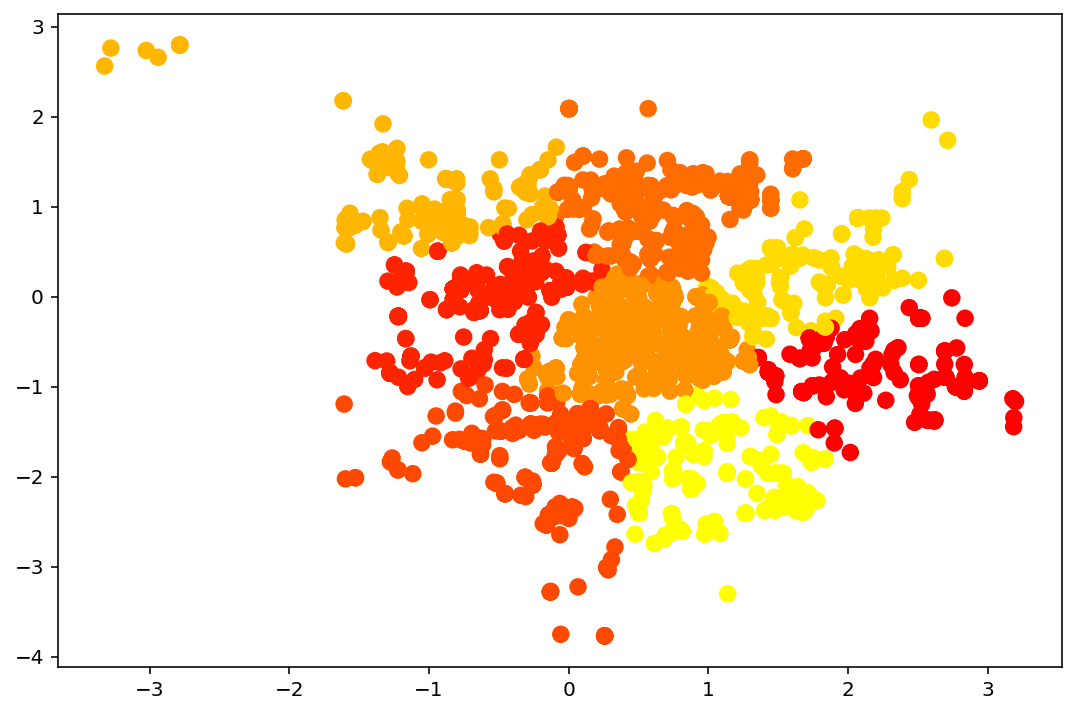

In [144]:
kmeans = KMeans()
out = kmeans.fit_predict(no[['x', 'y']])

plt.scatter(no.x, no.y, c=out, cmap='autumn', s=60)
plt.show()

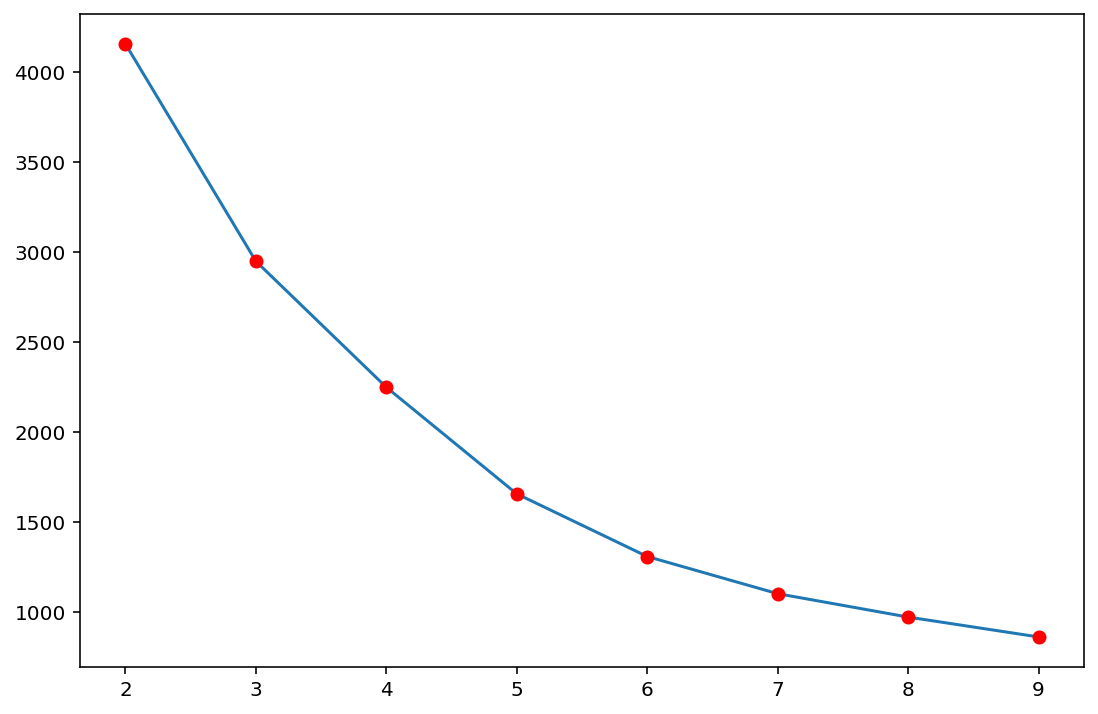

In [145]:
intertias = []
ks = list(range(2, 10))

for k in ks:
    mns = KMeans(n_clusters=k)
    mns.fit(no[['x', 'y']])
    intertias.append(mns.inertia_)

plt.plot(ks, intertias)
plt.plot(ks, intertias, 'ro');

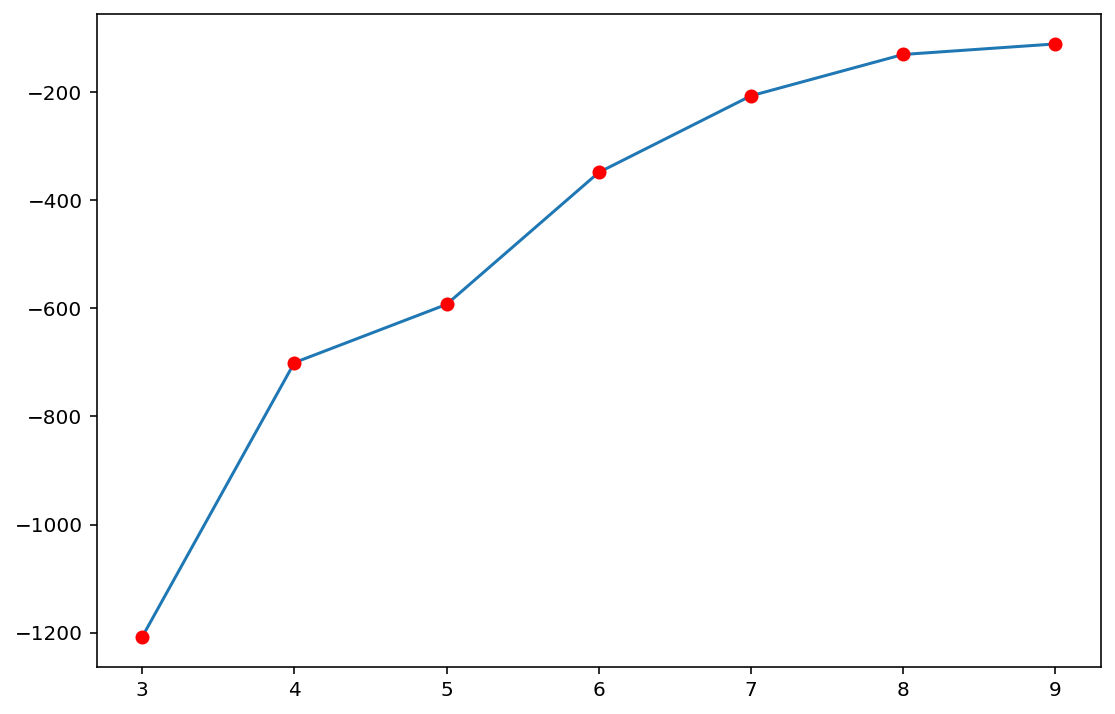

In [147]:
diff = np.diff(intertias)
plt.plot(ks[1:], diff)
plt.plot(ks[1:], diff, 'ro');

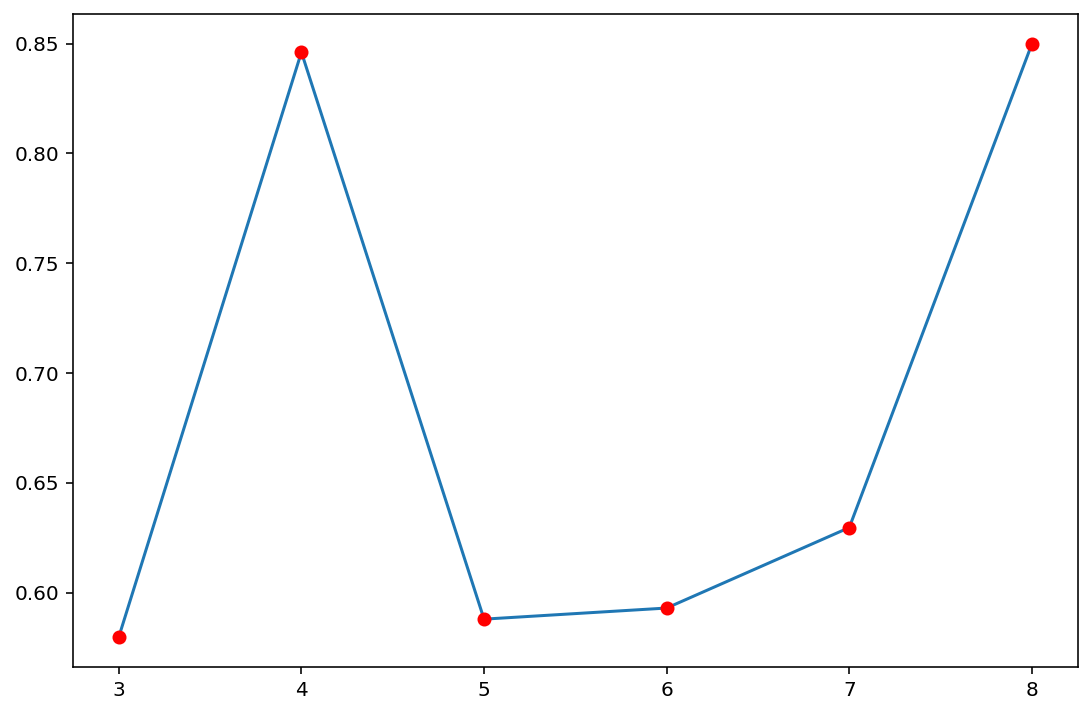

In [148]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)
plt.plot(ks[1:-1], diff_r, 'ro');

In [149]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

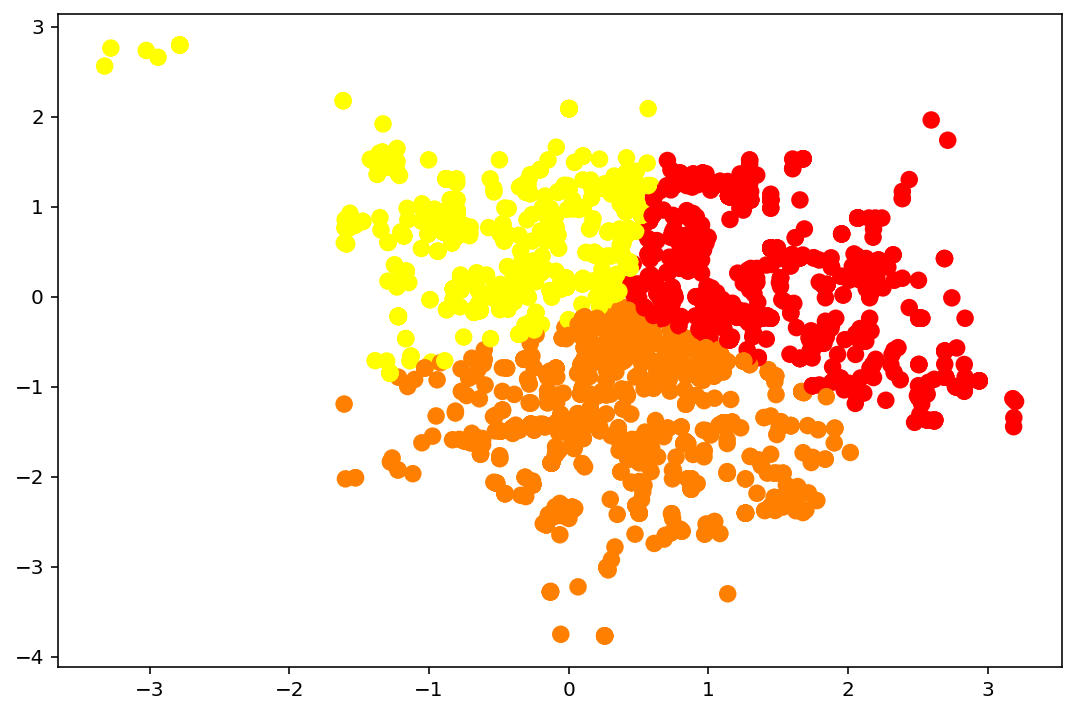

In [150]:
kmeans = KMeans(n_clusters=k_opt)
out = kmeans.fit_predict(no[['x', 'y']])

plt.scatter(no.x, no.y, c=out, cmap='autumn', s=60)
plt.show()

In [151]:
print('ARI: {}'.format(adjusted_rand_score(no.y, out)))
print('SIL: {}'.format(silhouette_score(no[['x', 'y']], out)))

ARI: 0.027994142932684495
SIL: 0.396163000589687


- Найти наиболее активные в голосовании районы

In [152]:
dbscan = DBSCAN(eps=0.2, min_samples=20)

In [153]:
clusters = dbscan.fit_predict(geo_comment_cleaned[['x', 'y']])
not_clustered = clusters == -1

In [154]:
x, y = geo_comment_cleaned['x'].values, geo_comment_cleaned['y'].values

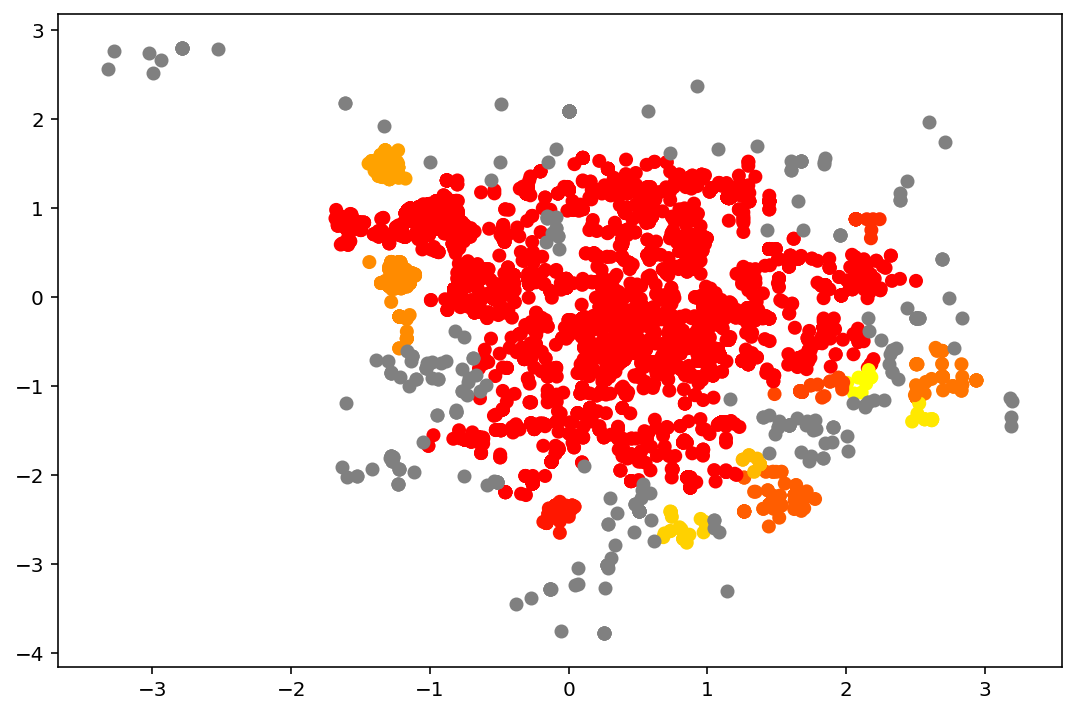

In [155]:
plt.scatter(x[~not_clustered], y[~not_clustered], c = clusters[~not_clustered], cmap = 'autumn')
plt.scatter(x[not_clustered], y[not_clustered], c = 'grey');

**Вывод:**
- данные слишком кучные, чтобы их кластеризовать
- выявить наибольшую активность можно по heatmap построенную выше

In [ ]:
pass